<p align="left">
  <img width="100%" src="docs/Banner.png">
</p>    

# InSAR Time Series Analysis: MintPy + ARIA GUNW products

**Author:** Zhang Yunjun, Heresh Fattahi, August 22-26, 2022 [UNAVCO InSAR Short Course (ISCE+)](https://www.unavco.org/event/2022-short-course-insar-processing-analysis-isce/).

The Miami INsar Timeseries software in PYthon (MintPy) is an open-source package for InSAR time-series analysis. MintPy currently starts from stacks of unwrapped interferograms (in either geo- or radar-coordinates) and estimates ground displacement time-series. MintPy is primarily consistent with stacks of interferograms processed with ISCE. However, the software also supports interfarograms processed with other InSAR processors such as GAMMA, GMTSAR, SNAP and ROI_PAC. 

MintPy is available on Github from the following page: https://github.com/insarlab/MintPy

References: The detailed algorithms implemented in MintPy can be found in the following paper: 

+ Yunjun, Z., Fattahi, H., Amelung, F. (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, _Computers & Geosciences, 133,_ 104331, doi:[10.1016/j.cageo.2019.104331](https://doi.org/10.1016/j.cageo.2019.104331), [arXiv](https://eartharxiv.org/9sz6m/), [data & figures](https://github.com/geodesymiami/Yunjun_et_al-2019-MintPy).

# Table of Contents

+ [0. Initial setup](#0.-Initial-setup-of-the-notebook)
+ [1. General overview](#1.-General-overview-of-smallbaselineApp.py)
   - [1.1 Processing steps](#1.1-Processing-steps-of-smallbaselineApp.py)
   - [1.2 Configuring the processing parameters](#1.2-Configuring-the-processing-parameters)
+ [2. Time series analysis](#2.-Time-series-analysis---small-baseline-approach)
+ [3. Error analysis](#3.-Error-analysis---what-is-signal,-what-is-noise!)
   - [3.1 Quality of the inversion](#3.1-Quality-of-the-inversion)
   - [3.2 Noise reduction of InSAR time series](#3.2-Noise-reduction-of-InSAR-time-series)
+ [4. Validation (comparing InSAR with GPS)](#4.-Validation---comparing-InSAR-with-GPS)
+ [5. Other MintPy functionalities](#5.-Other-MintPy-functionalities)

# 0. Initial setup of the notebook

The cell below performs the intial setup of the notebook and must be **run every time the notebook (re)starts**. It defines the processing location and check the example dataset.

In [6]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from ipynb.fs.full import utils  # optional, to import functions from *.ipynb files
from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy import view, tsview, plot_network, plot_transection
plt.rcParams.update({'font.size': 12})

# utils function
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process ARIA sample products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

# define and go to the work directory
work_dir = os.path.expanduser('~/data/SanFranSenDT42/mintpy')
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print('Go to work directory:', work_dir)

Go to work directory: /Users/yunjunz/data/SanFranSenDT42/mintpy


Run the cell below to 1) download the staged stack of interferograms or 2) to download and prepare the stack of interferograms using ARIA-tools. We have pre-processed an example ARIA dataset on San Francisco Bay and uploaded it to AWS and [Zenodo](https://zenodo.org/record/6990323), one could also run ARIA-tools commands to download and pre-process themselves, by setting `use_staged_data` below.

If the user has already prepared the ARIA data, then the data preparation can be skipped. Please see the [example data directory](https://mintpy.readthedocs.io/en/latest/dir_structure/) about setting up the stack for MintPy processing. 

In [ ]:
# download/prepare the interferogram stack from ARIA products and load into mintpy
# aws    - download pre-processed data from AWS S3 bucket [recommended, requires awscli]
# zenodo - download pre-processed data from zenodo using wget
# False  - download & pre-process from ARIA using ARIA-tools
use_staged_data = 'aws'  #['aws' / 'zenodo' / False]

if all(os.path.isfile(os.path.join(work_dir, 'inputs', x)) for x in ['ifgramStack.h5', 'geometryGeo.h5']):
    print('ARIA products are already loaded into MintPy. Skip re-loading.')

elif use_staged_data in ['aws', 'zenodo']:
    # option 1: download the staged data from AWS or Zenodo
    os.chdir(os.path.dirname(os.path.dirname(work_dir)))
    tar_file = os.path.join(os.path.dirname(os.path.dirname(work_dir)), 'SanFranSenDT42.tar.lz4')
    if os.path.isfile(tar_file):
        print('Staged ARIA product exists at: {}'.format(tar_file))
    elif use_staged_data == 'aws':
        !aws --region us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/unavco2022/SanFranSenDT42.tar.gz ./
    elif use_staged_data == 'zenodo':
        !wget https://zenodo.org/record/6990323/files/SanFranSenDT42.tar.gz ./

    # decompress the tar file [it takes ~1 min]
    !pv SanFranSenDT42.tar.gz | tar -xv
    os.chdir(work_dir)

elif use_staged_data is False:
    # option 2: download / prepare ARIA products using ARIA-tools, and load into MintPy
    aria_stack_files = [os.path.join(work_dir, f'../stack/{x}Stack.vrt') for x in ['unwrap', 'coh', 'connComp']]
    if all(os.path.isfile(x) for x in stack_files):
        print('ARIA products already exists at: {}'.format(os.path.dirname(work_dir)))
    else:
        print("Using ARIA-tools to download and prepare the input data for MintPy")
        os.chdir(os.path.dirname(work_dir))
        !ariaDownload.py -b '37.25 38.1 -122.6 -121.75' --track 42
        !ariaTSsetup.py -f 'products/*.nc' -b '37.25 38.1 -122.6 -121.75' --mask Download --num_threads 4 --verbose
        os.chdir(work_dir)
    # load ARIA products into MintPy
    !prep_aria.py -s ../stack/ -d ../DEM/SRTM_3arcsec.dem -i ../incidenceAngle/*.vrt -a ../azimuthAngle/*.vrt -w ../mask/watermask.msk --update

    # compress for staging
    # tar cvzf SanFranSenDT42.tar.gz SanFranSenDT42
else:
    raise ValueError(f'un-recognized "use_staged_data" setting: {use_staged_data}\navailable settings: "aws", "zenodo", False.')

# 1. General overview of smallbaselineApp.py

This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries. The workflow consists of two main blocks:

* correcting for unwrapping errors and inverting for the raw phase time-series (blue ovals),
* correcting for noise from different sources to obtain the displacement time-series (green ovals).

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through the various steps.

<p align="left">
  <img width="600" src="docs/smallbaselineApp_workflow.png">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 1.1 Processing steps of smallbaselineApp.py

The smallbaselineApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, which allows to re-start the processing from a given step. More detailed usage can be found in help.

In [ ]:
!smallbaselineApp.py --help

The app includes the following processing steps:

#### Input

* `load_data:` loads the stack of unwrapped interferograms, coherence files, connected componenents, baseline, incidence angle and other metadata into HDF5 files with multiple datasets and attributes.  

#### Network inversion for time-series

* `modify_network:` this step (if requested) modifies the network of interferograms, e.g., based on average coherence, temporal and spatial baselines threshold, or by removing specific pairs.
* `reference_point:` the unwrapped interferograms may be relative to differnt reference pixels. This step introduces a common reference pixel to all interferograms. For intuitive interpretation, one may choose a stable coherent non-deforming pixel. However, since the estimated InSAR displacement time-series is relative in both time and space, choosing a deforming pixel does not change the results.
* `quick_overview:` this step provides a quick assessment of:
   1. expected rate maps even before inversion by simply averaging / stacking the unwrapped interferograms;
   2. distribution of unwrapping errors from the number of interferogram triplets with non-zero integer ambiguity.
* `correct_unwrap_error:` the input unwrapped interferograms may be affected by phase unwrapping errors (wrong integer number of $2\pi$ phase added during phase unwrapping). This step (if requested) offers three methods to possibly correct unwrapping errors.
* `invert_network:` inverts the stack of unwrapped interferograms to form the InSAR phase time-series. This is equivalent to transforming the network of small-baseline interferograms to a single-reference network of interferogram (i.e., the unwrapped phase timeseries). 

#### Noise reduction of displacement time-series

* `correct_LOD:` this step is specific to Envisat data and applies an empircal correction to account for possible local oscilator drift of the radar.
* `correct_SET:` corrects (if requested) the solid Earth tides due to the gravity pull from the Sun and the Moon.
* `correct_troposphere:` corrects tropospheric delay 1) using atmospheric models or 2) with empirical phase elevation approach estimated from InSAR data.
* `deramp:` this step (if requested) removes a ramp from each acquisition. Note that deramping removes residual long-wavelength interferometric phase components which may be due to noise (geometrical residual, atmospheric delay) or signal (tectonic deformation).  
* `correct_topography:` estimates residual topographic effects (due to DEM errors) which are correlated with temporal variation of perpendicular baseline.  
* `residual_RMS:` estimates the average noise level for each acquisition by calculating the RMS of the residual phase
* `reference_date:` change reference date
* `velocity:` estimates the average velocity

#### Output

* `geocode:` if the original stack in radar-coordinates, convert it to geo-coordinates in lat/lon
* `google_earth:` output the average velocity into an Google Earth KMZ file.
* `hdfeos5:` output the displacement time-series with geometry info into one file in [HDF-EOS5](http://hdfeos.org) format.

## 1.2 Configuring the processing parameters

The processing parameters for the smallbaselineApp.py are configured through two configuration files. At least one configuration is required to run smallbaselineApp.py.

* `default configuration`: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp.cfg). It contains all configuration parameters, grouped by steps, with default auto values (which are defined in [smallbaselineApp_auto.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp_auto.cfg)). This file is copied over to the current working directory and read every time smallbaselineApp.py runs.
* `custom configuration` (optional but recommended): `SanFranSenDT42.txt` in the example dataset. It constains selective, manually modified configuration parameters. The custom template file name is arbitrary. Custom template has higher priority than the default template; if custom template is input, smallbaselineApp.py will update the default smallbaselineApp.cfg file accordingly.

### Custom configuration for the dataset in this notebook

Run the following to create an text file named _SanFranSenDT42.txt_ with the following few lines in it:

In [ ]:
CONFIG_TXT = '''# vim: set filetype=cfg:
mintpy.load.processor      = aria  #[isce, aria, hyp3, gmtsar, snap, gamma, roipac], auto for isce
#---------interferogram datasets:
mintpy.load.unwFile        = ../stack/unwrapStack.vrt
mintpy.load.corFile        = ../stack/cohStack.vrt
mintpy.load.connCompFile   = ../stack/connCompStack.vrt
#---------geometry datasets:
mintpy.load.demFile        = ../DEM/SRTM_3arcsec.dem
mintpy.load.incAngleFile   = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile    = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile  = ../mask/watermask.msk
mintpy.reference.lalo           = 37.69, -122.07

mintpy.troposphericDelay.method = no
mintpy.deramp                   = no
mintpy.topographicResidual      = no

# options to speedup the processing (fast but not the best)
mintpy.networkInversion.weightFunc           = no
mintpy.topographicResidual.pixelwiseGeometry = no
'''

config_file = os.path.join(work_dir, "SanFranSenDT42.txt")
write_config_file(config_file, CONFIG_TXT, mode='w')

<div class="alert alert-warning">
<b>Question:</b> 
What are the inputs to MintPy? Are multiple pairs of interferograms produced by topsApp.py a stack?
</div>

<p align="left">
  <img width="400" src="docs/ifgram_stack.png">
</p>     

Check **more examples for custom template** on [here](https://github.com/insarlab/MintPy/tree/main/mintpy/data/input_files).

Check **more example input file paths** for ISCE direct outputs as well as outputs from GAMMA, SNAP GMTSAR and ROI_PAC on [here](https://mintpy.readthedocs.io/en/latest/dir_structure/).

# 2. Time series analysis - small baseline approach

## 2.1 Load the ARIA data into MintPy

MintPy is most consistent with the ISCE direct outputs. However, it supports interferograms processed with other InSAR software including Gamma and SNAP. In this tutorial we are not using the direct ISCE outputs, but rather we use the ISCE outputs packaged by ARIA and pre-processed using [ARIA-tools](https://github.com/aria-tools/ARIA-tools). 

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep load_data

By running this command, the "inputs" directory inside the working directory is created and two HDF5 files are produced as

In [ ]:
ls -l inputs

`ifgramStack.h5:` this file contains 6 dataset cubes and multiple metadata.

```
date             - 2D array in size of (m, 2) in YYYYMMDD format for the reference and secondary dates (1st and 2nd columns).
bperp            - 1D array in size of (m,) in meter for perpendicular baselines (average value)
coherence        - 3D array in size of (m, l, w) for spatial coherence                data cube
connectComponent - 3D array in size of (m, l, w) for connected commponents            data cube
unwrapPhase      - 3D array in size of (m, l, w) for unwrapped interferometric phases data cube
dropIfgram       - 1D array in size of (m,) in boolean to indicate whether an interferogram is used for inversion or ignored
```

where `m` is the number of interferograms, `l` is the number of lines and `w` is the number of columns.

`geometryGeo.h5:` this file contains geometrical datasets including height, incidence angle, azimuth angle, shadow layover mask, slant range distance and/or water mask. 

Check more detailed description of the data structure [here](https://mintpy.readthedocs.io/en/latest/api/data_structure/).

<div class="alert alert-info">
<b>info.py:</b> 
To get general infomation about a MintPy product, run info.py on the file. Similar to "gdalinfo".   
</div>

In [ ]:
# !gdalinfo inputs/geometryGeo.h5
!info.py inputs/geometryGeo.h5

In [ ]:
!info.py inputs/ifgramStack.h5

In [ ]:
!info.py inputs/ifgramStack.h5 --date --num

## 2.2 Plot the interferogram network

Before inversion, it's useful to take a look at the network of interferograms. Running `plot_network.py` gives an overview of the network and the average coherence of the stack. 

read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
calculating spatial mean of coherence in file inputs/ifgramStack.h5 ...
read mask from file: waterMask.h5
[==================================================] 961/961   28s /     0s 
write average value in space into text file: coherenceSpatialAvg.txt
number of acquisitions: 189
number of interferograms: 961
shift all perp baseline by 0.606631875038147 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 961
number of acquisitions marked as drop: 0
max perpendicular baseline: 226.68 m
max temporal      baseline: 456.0 days
showing coherence
data range: [0.45670286, 0.9486475]
display range: (0.2, 1.0)
showing ...


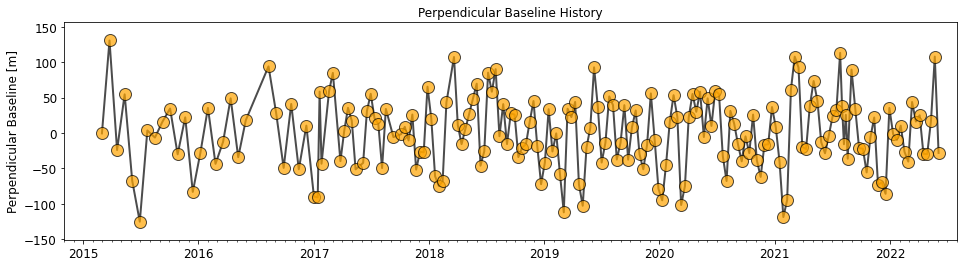

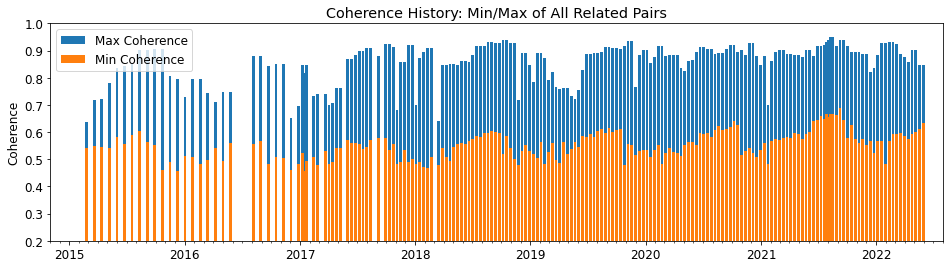

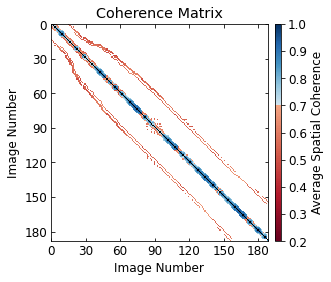

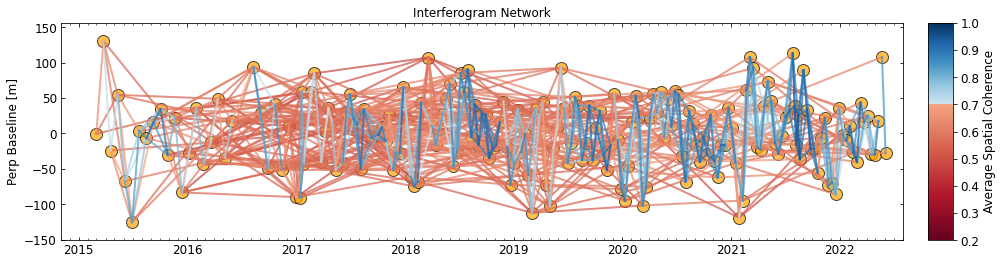

In [40]:
plot_network.main('inputs/ifgramStack.h5 -t smallbaselineApp.cfg --figsize 16 4'.split())

Note that with the `--nodisplay` argument, the plots won't be displayed but saved as pdf files in the current directory. Running this command creates multiple files as follows:

+ `coherenceSpatialAvg.txt`: A simple text file that provides an overview to the stack and contains the interferogram dates, average coherence temporal and spatial baseline separation.
+ `network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. Circles represent the acquisition dates and lines represent the interferograms. Solid lines are the interferograms used for time-series analysis and dashed line are the interferograms ignored in the time-series analysis. 
+ `coherenceMatrix.pdf`: Shows the avergae coherence pairs between all available pairs in the stack.

## 2.3 Generate masks before runing time-series

Before running the time-series inversion, one may want to looks at average coherence in the stack. To create a map of average spatial coherence use `temporal_average.py`:

In [ ]:
!temporal_average.py ./inputs/ifgramStack.h5 -d coherence -o avgSpatialCoh.h5
view.main('avgSpatialCoh.h5 --noverbose'.split())
# equivalent command in terminal: view.py avgSpatialCoh.h5 --noverbose

Also one may optionally extract the water mask from the geometry file to be used later for masking the time-series results:

In [ ]:
!generate_mask.py inputs/geometryGeo.h5 waterMask --nonzero -o waterMask.h5
view.main('waterMask.h5 -c gray --noverbose'.split())

In [ ]:
!generate_mask.py  inputs/ifgramStack.h5 --nonzero -o maskConnComp.h5 --update
view.main('maskConnComp.h5 -c gray --noverbose'.split())

## 2.4 Select reference point

The interferometric phase is relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore we need to reference all interferograms to a common reference pixel.
The step "reference_point" selects a common reference pixel for the stack of interferograms. The default approach of mintpy is to choose a pixel with highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.    

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep reference_point

Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the ifgramStack.h5 file. To see the attributes of the file run info.py:

In [ ]:
!info.py inputs/ifgramStack.h5 | egrep 'REF_'

Note that reference_point does not change the actual values of the unwrapped phase dataset. However, MintPy takes into account the phase at the reference point while performing the time-series inversion. 

## 2.5 Invert network of interferograms for time-series

In the next step we invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date, which by default is the first acquisition. The estimated time-series is converted to distance change from radar to target and is provided in meters.  

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep invert_network

The main product generated after running inver_network step, is timeseries.h5. To see the general content of the file run info.py

In [ ]:
!info.py timeseries.h5 --compact

The timeseries file contains three datasets, the time-series which is the interferometric range change for each acquisition relative to the reference acquisition, the "date" dataset which contains the acquisition date for each acquisition and the bperp dataset which contains the timeseries of the perpendicular baseline.  

In [ ]:
view.main('timeseries.h5 -v -5 5 --noaxis'.split())
# equivalent command in terminal: view.py timeseries.h5 -v -5 5 --noaxis

<div class="alert alert-warning">
<b>Question:</b> 
Why we invert a network of small baseline interferograms to estimate a single reference time-series, instead of forming the single-reference network of interferograms at first place? 
</div>

## 2.6 Time-series to velocity

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. The step "velocity" estimates the rate of the displacement. 

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep velocity
# rename the output velocity file, for later-on comparison
!mv velocity.h5 velocityRaw.h5

In [ ]:
%matplotlib widget
opt = '--dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour -v -1 1 --lalo-label --ylabel-rot 90 --figsize 10 8'
view.main(f'velocityRaw.h5 velocity {opt}'.split())

<div class="alert alert-info">
<b>Note:</b> 
Negative values indicates that target is moving away from the radar (i.e., subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation).
</div>

Obvious features in the estimated velocity map:

1) The general pattern of displacement is consistent with tectonic setting of the region. Pacific plate is moving north-west with respect to North american plate. The satellites is on a descending track and the estimated displacement shows the blue region is moving away from the red region. 

2) The magnitude of the relative movement (blue region relative to red region) is about ~13 mm/yr in radar Line-Of-Sight (LOS) direction which is consistent with ~40 mm/yr horizontal movements of pacific relative to north america.

3) The estimated velocity shows a linear feature almost aligned with the south-east north-west diagonal of the map. This linear feature shows the aseismic fault creep on Hayward fault. 

4) Around latitude 38.0N, another linear feature represents Concord fault parallel to Hayward fault.

5) Around latitude 37.9N, a east-west linear discontinuity is evident. This is most likely caused by unwrapping errors due to imperfect phase stitching with frame-by-frame processing.

6) Around latitude 37.4N at Salta Clara Valley, a linear feature represents the Silver Creek Fault, mixed together with a hydrological signals showing ground deformation caused by acquifer recharge (Schmidt and Bürgmann, 2003; Chaussard et al., 2014).

7) The block box at [37.69N, 122.07W] is the reference pixel for this map. 

Reference:
+ USGS, Quaternary Fault and Fold Database of the United States (https://www.usgs.gov/programs/earthquake-hazards/faults)

<div class="alert alert-info">
<b>Note:</b> 
For an interactive plot of tinme-series for each pixel, use the tsview.ipynb jupyter notebook. From a terminal one may directly call the tsview.py to display InSAR time-series. 
</div>

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

In [ ]:
%matplotlib inline
view.main('velocityRaw.h5 velocityStd -v 0 0.1'.split())

The estimated standard deviation only represents the goodness of fit and can be biased or maybe under-estimating the actual uncertainty of the product. However, the spatial pattern of the estimated standard deviation is interesting and clearly shows the spatial correltion of noise in the time-series. The uncertainty is distance dependent and increases with increasing distance between pixels. This map shows the uncertainty for each pixle relative to the reference pixel. 

<div class="alert alert-warning">
<b>Question:</b> 
What are the sources of errors that can potentially increase the uncertainty or bias the estimated velocity at this stage?  
</div>

# 3. Error analysis - what is signal, what is noise!

Anatomy of interferometric phases:

$$ \large \Delta \phi = \color{green}{ \Delta\phi_{defo} + \Delta\phi_{atm} + \Delta\phi_{geom} + \Delta\phi_{tidal}} + \color{royalblue}{ \Delta\phi_{non-closure}} $$

where $\color{green}{\Delta\phi_{atm}}$ includes ionospheric and tropospheric delays, $\color{green}{\Delta\phi_{geom}}$ includes the topographic residual (DEM error) and orbital error, $\color{green}{\Delta\phi_{tidal}}$ includes solid Earth tides, ocean tidal loading, etc. $\color{royalblue}{\Delta\phi_{non-closure}}$ includes all phase contributions that does not fulfill the zero phase closure of interferogram triplets, including:
+ decorrelation noise
+ potential phase-unwrapping errors (Yunjun et al., 2019)
+ processing inconsistency due to filtering and multilooking (Agram & Simons, 2015) [negligible]
+ non-closure phases from short temporal baseline interferograms (Ansari et al., 2021; Zheng et al., 2022).

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in mintpy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 3.1 Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 3.1.1 Quality measure: average spatial coherence vs. temporal coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion. 

In addition to timeseries.h5 which contains the time-series dataset, "invert_network" produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms (Pepe and Lanari, 2006). 

$$ \large \gamma_{temp}=\frac{1}{M}|H^T\exp[j(\Delta\phi-A\hat{\phi})]|$$

where $\Delta\phi$ is the interferometric unwrapped phase, $A$ is the design matrix, $\hat{\phi}$ is the estimated time-series, $H$ is an $M\times1$ all-ones column vector, $j$ is the imaginary unit.

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

In [ ]:
view.main('avgSpatialCoh.h5 --noverbose'.split())
view.main('temporalCoherence.h5 --noverbose'.split())

<div class="alert alert-warning">
<b>Question:</b> 
For a network of interferograms with only one interferogram between each acquisition and subsequent acquisition (sequential network of interferograms), how the temporal coherence looks like? Can the temporal coherence be trusted in this case?
</div>

<div class="alert alert-warning">
<b>Question:</b> 
Generally, the temporal coherence may resemble the spatial pattern of the average spatial coherence. Under what condition, an area with high average spatial coherence may show low temporal coherence?  
</div>

### 3.1.2 Phase unwrapping error

#### a. Error detection

The interferometric phases are wrapped (modulo 2$\pi$) and integration of the wrapped phase, commonly called phase unwrapping, is required to obtain a field of relative phase with respect to a given pixel. The phase unwrapping algorithms add integer number of 2$\pi$ phase jumps to recover the unwrapped phase. Interferometric phase noise and discontinuities among different coherent regions may lead to wrong 2$\pi$ jumps added to the phase field known as unwrapping error. Unwrapping errors can bias the estimated time-series. 

By looking at the temporal coherence we suspect that some of the interferograms may have missing frames or may have wrong stitching. Let's first plot all interferograms and visually investigate any problem with some pairs. 

In [ ]:
view.main('inputs/ifgramStack.h5 unwrapPhase-201604* -v -10 10 --zero-mask --noaxis --noverbose'.split())

It's obvious that the interferograms with the indices (100 and 101) have clear jumps at a burst boundary most likely caused by missing bursts in some acquisitions or due to problems in stitching.

For several stacks of interferograms, it's sometimes impractical to check every single interferogram for phase unwrapping errors. Below is a way for use one map to indicate potential phase unwrapping errors for the entire stack.

For an interferogram triplet ($\Delta\phi^{ij}$, $\Delta\phi^{jk}$ and $\Delta\phi^{ik}$), unwrapping errors will introduce an non-zero integer component $C_{int}^{ijk}$ in the closure phase $C^{ijk}$. Therefore, the number of interferogram triplets with non-zero integer ambiguity $T_{int}$ can be used to detect unwrapping errors:

$$ \large C^{ijk}=\Delta\phi^{ij}+\Delta\phi^{jk}-\Delta\phi^{ik}$$
$$ \large C_{int}^{ijk}=\frac{C^{ijk}-wrap(C^{ijk})}{2\pi}$$
$$ \large T_{int}=\sum_{i=1}^T(C_{int}^{ijk}!=0)$$

where $warp$ is an operator to wrap the input number into $[-\pi, \pi)$; $T$ is the number of interferogram triplets.

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep quick_overview
pp.plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', display=True, fig_size=[16, 4])

Take home messages from $T_{int}$ map and histogram:

1. Areas with $T_{int}$ > 0 have unwrapping errors.
2. Areas share the common positive $T_{int}$ value could be corrected.
3. Areas with wide-distributed $T_{int}$ value indicates random unwrapping errors, which are difficult to correct.

<div class="alert alert-warning">
<b>Question:</b> 
After time-series inversion, which metric better represents the quality of the inversion?
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A. Average spatial coherence
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B. Temporal coherence
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;C. Common mask from connected components
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;D. Water mask which indicates which pixel is water and which pixel is land
</div>

In [ ]:
# This command generates a multi-choice selection box for the question above.
# It requires `ipynb` and `ipywidgets`. If not working, no worries, just ignore this and continue.
utils.inv_quality

#### b. Error correction

MintPy provides three methods to possibly detect and correct the phase unwrapping errors (Yunjun et al., 2019, section 3). 

1. `bridging`: automating the traditional manual bridging method in which coherent components with the smallest distance from each other are assumed connected and therefore the a smooth phase variation across them are enforced. 
1. `phase_closure`: based on the phase closure of the triplets of the interferograms. 
3. `bridging+phase_closure`: a hybrid approach and simply uses the both approached mentioned before.

Note that to use the phase closure approach a dense network of interferograms should be available. To use the phase unwrapping error correction methods, usually a common mask is generated, which shows pixels with valid unwrapped phase in all interferograms. 

The phase unwrapping error correction can be turned ON using `mintpy.unwrapError.method` option, and further customized using the [template options](https://github.com/insarlab/MintPy/blob/47bb7f67e7e1f153e2af0d9e3dd236da07cf4b4e/mintpy/defaults/smallbaselineApp.cfg#L138-L162):

In [ ]:
write_config_file(config_file, "mintpy.unwrapError.method = bridging")

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep correct_unwrap_error

Plotting the interferogram after unwrapping error correction shows how well the correction is.

In [ ]:
view.main('inputs/ifgramStack.h5 unwrap*20160131_20170302 conn*-20160131_20170302 --zero-mask --figsize 15 5 --noverbose'.split())

After correcting for unwrapping errors, we need to re-run the inversion to see the impact of the unwrapping error correction.

### 3.1.3 Modify the Network of interferograms

This step enables modifying the network of interferograms before the network inversion. Motivation:

+ Drop low coherent interferograms, to mitigate the impact of decorrelation noise / increase the spatial coverage.
+ Drop interferograms with phase unwrapping errors, that could not be corrected for successfully.

Several options exist to modify a network.

+ Based on an average coherence value over the entire interferogram (optionally masked area), or over an area of interest.
+ Based on temporal and perpendicular baseline thresholds, maximum number of connections between each acquisition and following acquisitions, or simply by excluding dates or interferogram pairs or their indices.

All different network modification options can be configured through the configuration file in [the `mintpy.network.*` group](https://github.com/insarlab/MintPy/blob/47bb7f67e7e1f153e2af0d9e3dd236da07cf4b4e/mintpy/defaults/smallbaselineApp.cfg#L77-L110).

<div class="alert alert-info">
<b>TIP:</b> 
For coherence-based network modification, a customized area of interest (AOI) that includes the low coherence pixels of interest is recommended. E.g. the Sierra Negra caldera in the example ALOS dataset below.
</div>

<p align="left">
  <img width="600" src="docs/net_modification.jpg">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

<div class="alert alert-info">
<b>TIP:</b> 
For best results, we recommend (if possible) users process a redundant network of interferograms to have more freedom to modify the network before the inversion. 
</div>

<div class="alert alert-info">
<b>NOTE:</b> 
By modifying the network, the interferograms are not physically removed. However the value for that interferogram in the dropIfgram dataset in ifgramStack.h5 turns to False.  
</div>

### 3.1.4 Weighted network inversion

The following weighted least squares (WLS) inversions methods are supported:

```cfg
## Invert network of interferograms into time-series using weighted least sqaure (WLS) estimator.
## weighting options for least square inversion [fast option available but not best]:
## a. var - use inverse of covariance as weight (Tough et al., 1995; Guarnieri & Tebaldini, 2008) [recommended]
## b. fim - use Fisher Information Matrix as weight (Seymour & Cumming, 1994; Samiei-Esfahany et al., 2016).
## c. coh - use coherence as weight (Perissin & Wang, 2012)
## d. no  - uniform weight (Berardino et al., 2002) [fast]
## SBAS (Berardino et al., 2002) = minNormVelocity (yes) + weightFunc (no)
mintpy.networkInversion.weightFunc      = auto #[var / fim / coh / no], auto for var
```

By default MintPy uses the same network of interferograms for all the pixels. However, it is possible to use variable networks for different pixels by specifying a mask dataset, a threshold value for the mask and a minimum redundance value: 
  
```cfg
## mask options for unwrapPhase of each interferogram before inversion (recommed if weightFunct=no):
## a. coherence        - mask out pixels with spatial coherence < maskThreshold
## b. connectComponent - mask out pixels with False/0 value
## c. no               - no masking [recommended].
## d. offsetSNR        - mask out pixels with offset SNR < maskThreshold [for offset]
mintpy.networkInversion.maskDataset   = auto #[coherence / connectComponent / offsetSNR / no], auto for no
mintpy.networkInversion.maskThreshold = auto #[0-inf], auto for 0.4
mintpy.networkInversion.minRedundancy = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition
```

<div class="alert alert-info">
<b>NOTE:</b> 
If you choose to use variable network for different pixels, then interpret the temporal coherence with caution as the temporal coherence for a network with only one connection between each acquisition and next acquisition is 1. A by product named numInvIfgram.h5 shows the number of interferograms used in the inversion for each pixel.
</div>

MintPy by default masks the estimated time-series using temporal coherence with a threshold:

```cfg
## Temporal coherence is calculated and used to generate the mask as the reliability measure
## reference: Pepe & Lanari (2006, IEEE-TGRS)
mintpy.networkInversion.minTempCoh  = auto #[0.0-1.0], auto for 0.7, min temporal coherence for mask
mintpy.networkInversion.minNumPixel = auto #[int > 1], auto for 100, min number of pixels in mask above
mintpy.networkInversion.shadowMask  = auto #[yes / no], auto for yes [if shadowMask is in geometry file] or no.
```

The least squares inversion can be performed using phase (matrix $A$ in Berardino et al, 2002) or using phase velocity (matrix $B$ in Berardino at al, 2002). The latter allows to invert a disconnected network. For a connected network, the design matrix is full-rank and the inversion using either methods are the same.

```cfg
mintpy.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity or phase
```

### 3.1.5 Re-inverting network of interferograms after error correction

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep invert_network

Let's check how the temporal coherence looks like after removing those interferograms. 

In [ ]:
view.main('temporalCoherence.h5 --noverbose'.split())

Note that the temporal coherence at the top has increased and the discontinuity has disapeared.

<div class="alert alert-warning">
<b>Question:</b> 
If someone is interested only in the timeseries at one of the islands arround latitude 37.9N, where the reference pixel should be put in?</div>

## 3.2 Noise reduction of InSAR time-series

After inversion of the network of interferograms, the estimated time-series contains different components including tropospheric delay, topographic residuals, ground displacement and other possible geophysical components (e.g., tide, ionosphere if they have not been corrected) or instrumental effects (e.g., the local oscilator drift of Envisat). Given ground displacement as our signal of interest, the following processing steps attempt to separate signal from noise and provide a ground displacement time-series for selected coherent pixels.

### 3.2.1 Tropospheric delay correction

This step corrects the tropospheric phase delay. Thress methods are supported:

+ Global Atmospheric Models (GAMs) using [PyAPS](https://github.com/insarlab/PyAPS) (Jolivet et al., 2011; 2014).
+ Generic Atmospheric Correction Online Service for InSAR ([GACOS](http://www.gacos.net/)) (Yu et al., 2018)
+ Empirical relationship between stratified tropospheric delay and topography (Doin et al., 2009).

The corresponding template options are:

```cfg
## correct tropospheric delay using the following methods:
## a. pyaps - use Global Atmospheric Models (GAMs) data (Jolivet et al., 2011; 2014)
##      supports ERA5 from ECMWF [recommended]
## b. gacos - use GACOS with the iterative tropospheric decomposition model (Yu et al., 2018a, RSE; 2018b, JGR)
##      need to manually download GACOS products at http://www.gacos.net for all acquisitions before running this step
## c. height_correlation - correct stratified tropospheric delay (Doin et al., 2009, J Applied Geop)
mintpy.troposphericDelay.method = auto  #[pyaps / gacos / height_correlation / no], auto for pyaps
```

It outputs:
+ timeseries_ERA5.h5: the troposphere-corrected time-series (ERA5 data is selected in this case).
+ inputs/ERA5.h5: the estimated tropospheric phase delay time-series (for pyaps and gacos method only).

<div class="alert alert-info">
<b>NOTE:</b> 
ERA5 data set is redistributed over the Copernicus Climate Data Store (CDS). Registration is required for the data access and downloading. Check PyAPS website (https://github.com/insarlab/PyAPS) for more details.
</div>

### 3.2.2 Solid Earth tides correction

This step corrects the solid Earth tides due to the gravity pull from the Sun and the Moon using [PySolid](https://github.com/insarlab/pysolid) (Yunjun et al., 2022), which implements the IERS (International Earth Rotation and Reference Systems Service) 2010 Conventions (Petit & Luzum, 2010).

```cfg
mintpy.solidEarthTides = auto #[yes / no], auto for no
```

### 3.2.3 Bulk plate motion

The bulk motion of tectonic plates (up to several cm/year) can introduce a long-wavelength spatial gradient in mm/year level over several 100km scale ([Stephenson et al., GRL, under review](https://www.essoar.org/doi/10.1002/essoar.10511538.2)), when projecting into the line-of-sight (LOS) direction with range-dependent incidence angle (and to a lesser extent, azimuth angle), as shown below. This impact can be accounted for using exsiting plate motion models, such as the ITRF2014-PMM ([Altamimi et al., 2017](https://doi.org/10.1093/gji/ggx136)). The method is implemented in MintPy (since version 1.4.0) as [`bulk_plate_motion.py`](https://github.com/insarlab/MintPy/blob/main/mintpy/bulk_plate_motion.py). Run `bulk_plate_motion.py --help` for more detailed usage.

<p align='left'>
    <img width="500" src="docs/pmm_ramp.jpg">
</p>
<p style="text-align: left;">
    (Figure from Stephenson et al., under review)
</p>

### 3.2.4 Non-closure phase related bias

Recent studies show that using small temporal baseline interferograms may result in biased displacement time-series ([Ansari et al., 2021, TGRS](https://ieeexplore.ieee.org/abstract/document/9130052)). This biased estimation has been confirmed in several studies and linked to the non-zero closuer phase, i.e. $\Delta\phi^{ij}+\Delta\phi^{jk}-\Delta\phi^{ik} \neq 0$. [Zheng et al. (2022, TGRS)](https://ieeexplore.ieee.org/document/9758802) have developed a simple model explaining both the non-zero closure phase and the observed systematic "bias", showing that the **non-zero closure phase can be an indicator of temporally inconsistent physical processes** that alter both the phase and amplitude of interferometric measurements.

The model/algorithm from Zheng et al. (2022) can be used to estimate / correct for this "bias", and has been implemented into MintPy (since version 1.4.0) as [`closure_phase_bias.py`](https://github.com/insarlab/MintPy/blob/main/mintpy/closure_phase_bias.py). The figure below shows the average velocity maps from small baseline approaches using bandwidth-1, bandwidth-5, and bandwidth-10; and how these descrepancies can be estimated and removed.

<p align='left'>
    <img width="1000" src="docs/drylake_cp_vel.jpg">
</p>
<p style="text-align: center;">
    (Figure from Zheng et al., 2022)
</p>

In this notebook, we will demonstrate only the **detection of potential non-closure phase bias** using `closure_phase_bias.py -a mask`. The acutal bias estimation and correction can be found in another dedicated notebook tutorial with example dataset at [insarlab/MintPy-tutorial/closure_phase_bias.ipynb](https://github.com/insarlab/MintPy-tutorial/blob/main/applications/closure_phase_bias.ipynb).

Following on Zheng et al. (2022), we can calculate the average sequential closure phase $\bar{C_n}$ as:

$$ \bar{C_n} = \sum_{k=1}^{K} e^{j C_n^k} \,/\, K $$

$$C_n^k = \Delta\phi^{k,k+1} + \Delta\phi^{k+1,k+2} + ... + \Delta\phi^{k+n-1,k+n} - \Delta\phi^{k,k+n}$$

where $K$ is the number of available sequential closure phase, $n$ is the assumed bias free connection level, beyond which the closure phase bias is negligible. $C_n^k$ is the sequential closure phase with connection level-$n$ with starting acquisition $k$. E.g., $C_5^1 = \Delta\phi^{1,2} + \Delta\phi^{2,3} + \Delta\phi^{3,4} + \Delta\phi^{4,5} - \Delta\phi^{1,5}$. $\bar{C_n}$ is a complex number. By setting a threshold on both the amplitude and phase of $\bar{C_n}$, we can obtain a proxy map for regions susceptible to the closure phase bias.

Based on the network plot in section 2.2 above, we know there are near-complete interferograms for connection level 1, 2, 3 and 28. Therefore, we choose connection-level-28 below for the detection calculation below.

In [34]:
!closure_phase_bias.py -i inputs/ifgramStack.h5 -a mask --conn-level 28 --epsilon 0.4

setenv: Variable name must contain alphanumeric characters.

--------------------------------------------------------------------------------
calculating the mask to flag areas suseptible to non-closure-phase related biases (as zero) ...
number of valid acquisitions: 189 (20150301 - 20220604)
average complex closure phase threshold in amplitude/correlation: 0.4
average complex closure phase threshold in phase: 3 sigma (0.6 rad)

calculating the average complex closure phase
length / width: 1021 / 1021
maximum memory size: 4.0E+00 GB
split 1021 lines into 2 patches for processing
    with each patch up to 520 lines

------- processing patch 1 out of 2 --------------
box: (0, 0, 1021, 520)
box width:  1021
box length: 520
number of closure measurements expected: 161
number of closure measurements found   : 95
reference pixel in y/x: (493, 637) from dataset: unwrapPhase

------- processing patch 2 out of 2 --------------
box: (0, 520, 1021, 1021)
box width:  1021
box length: 501
number of

view.py avgCpxClosurePhase.h5 amplitude -c gray --lalo-label --lalo-step 0.5 --ylabel-rot 90 --noverbose --noscalebar
view.py avgCpxClosurePhase.h5 phase -c RdBu --lalo-label --lalo-step 0.5 --ylabel-rot 90 --noverbose --noscalebar
view.py maskClosurePhase.h5 -c gray_r --lalo-label --lalo-step 0.5 --ylabel-rot 90 --noverbose --noscalebar


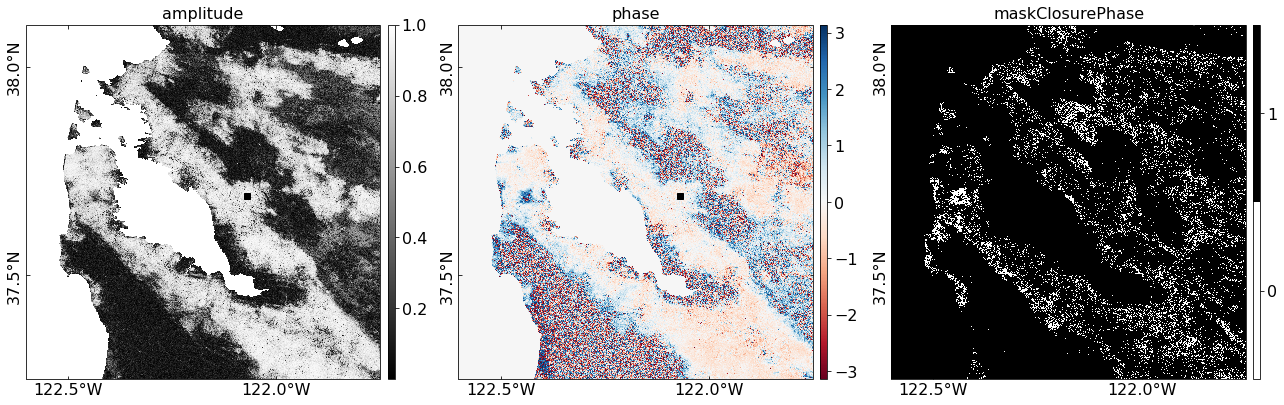

In [38]:
# view.py options
opt = ' --lalo-label --lalo-step 0.5 --ylabel-rot 90 --noverbose --noscalebar '
cmd_list = [f'view.py avgCpxClosurePhase.h5 amplitude -c gray {opt}',
            f'view.py avgCpxClosurePhase.h5 phase -c RdBu {opt}', #--lalo-loc 0 0 0 1 ',
            f'view.py maskClosurePhase.h5 -c gray_r {opt}',] # --lalo-loc 0 0 0 1 ',]

# plot using matplotlib & mintpy.view
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, cmd in zip(axs, cmd_list):
    data, atr, inps = view.prep_slice(cmd)=
    im = view.plot_slice(ax, data, atr, inps)[2]
fig.tight_layout()
plt.show()

Based on the result above, we know that:
+ ~12% of pixels on land (or ~20% of pixels with high temporal coherence value) are suspcetible to the non-closure phase related bias.
+ The primary affected regions includes: San Bruno Moutain State & County Park (~37.7N), the west side of San Andreas Fault.

### 3.2.5 Deramping (optional)

This step estimate and removes a linear or quadratic ramp from each acquisition based on the phase of the reliable pixels. It's recommended for localized deformation signals, such as volcanic deformation, landslides and city subsidence; but not recommeded for long spatial wavelength deformation signals, such as interseismic deformation.

The cooresponding template options are:

```cfg
## Estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## Recommended for localized deformation signals, i.e. volcanic deformation, landslide and land subsidence, etc.
## NOT recommended for long spatial wavelength deformation signals, i.e. co-, post- and inter-seimic deformation.
mintpy.deramp          = auto  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation
```

It outputs a new time-series HDF5 file with suffix _ramp_: timeseries_ERA5_ramp.h5 in this example.

### 3.2.6 Topographic residual (DEM error) correction

This step corrects the phase residual caused by the inaccuracy of DEM (DEM error) using its relationship with the perpendicular baseline time-series (Fattahi and Amelung, 2013, IEEE-TGRS). The corresponding template options are:

```cfg
## reference: Fattahi and Amelung (2013, IEEE-TGRS)
## stepFuncDate      - Specify stepFuncDate option if you know there are sudden displacement jump in your area,
##    i.e. volcanic eruption, or earthquake, and check timeseriesStepModel.h5 afterward for their estimation.
## excludeDate       - Dates excluded for error estimation only
## pixelwiseGeometry - Use pixel-wise geometry info, i.e. incidence angle and slant range distance
##    yes - use pixel-wise geometry when they are available [slow; used by default]
##    no  - use mean geometry [fast]
mintpy.topographicResidual                   = auto  #[yes / no], auto for yes
mintpy.topographicResidual.polyOrder         = auto  #[1-inf], auto for 2, poly order of temporal deformation model
mintpy.topographicResidual.phaseVelocity     = auto  #[yes / no], auto for no - phase, use phase velocity for minimization
mintpy.topographicResidual.stepFuncDate      = auto  #[20080529,20100611 / no], auto for no, date of step jump
mintpy.topographicResidual.excludeDate       = auto  #[20070321 / txtFile / no], auto for exclude_date.txt
mintpy.topographicResidual.pixelwiseGeometry = auto  #[yes / no], auto for yes, use pixel-wise geometry info
```

It outputs:
+ timeseries_ERA5_ramp_demErr.h5: the topographic residual corrected time-series.
+ timeseriesResidual.h5: residual phase time-series of this least square inversion.
+ demErr.h5: the estimated DEM error.

In [ ]:
write_config_file(config_file, "mintpy.topographicResidual = yes")

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep correct_topography

To view the estimated DEM error:

In [ ]:
view.main(['demErr.h5', '--zero-mask'])

### 3.2.7 Residual RMS for noise evaluation

This step calculates the Root Mean Square (RMS) of the residual phase time-series for each acquisition; then it:
1. selects the date with the minimum RMS value as the optimal reference date.
2. detects the noisy acquisitions with RMS beyond the outlier detection threshold.

The corresponding template options are:
```cfg
## 1) Residual Phase Root Mean Square
## calculate the Root Mean Square (RMS) of residual phase time-series for each acquisition
## To get rid of long wavelength component in space, a ramp is removed for each acquisition
## Set optimal reference date to date with min RMS
## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
mintpy.residualRMS.maskFile = auto  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
mintpy.residualRMS.deramp   = auto  #[quadratic / linear / no], auto for quadratic
mintpy.residualRMS.cutoff   = auto  #[0.0-inf], auto for 3
```

It outputs:
+ rms_timeseriesResidual_ramp.txt: for RMS value of each acquisition
+ rms_timeseriesResidual_ramp.pdf: plot of the rms_timeseriesResidual_ramp.txt
+ reference_date.txt: date in YYYYMMDD format for the optional reference date
+ exclude_date.txt: date(s) in YYYYMMDD format for the noisy acquisitions (if at least one is detected).

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep residual_RMS

In [ ]:
pp.plot_timeseries_rms('./rms_timeseriesResidual_ramp.txt', fig_size=[16, 4])

In [ ]:
cat reference_date.txt

### 3.2.8 Changing the reference date

This step changes the reference date of all phase time-series files, based on the input template option:

```cfg
## reference all time-series to one date in time
## no     - do not change the default reference date (1st date)
mintpy.reference.date  = auto   #[reference_date.txt / 20090214 / no], auto for reference_date.txt
```

This step operates on the existing time-series files and does not output new files.

<div class="alert alert-info">
<b>Note:</b> 
The optimal reference date (default option) gives the time-series plot a "clean" looks only. Changing the reference is equivalent to adding a constant to the displacement time series, which does not change the velocity or any other information derived from the displacement time series.
</div>

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep reference_date

### 3.2.9 Re-estimating velocity after noise reduction

Noisy acquisitions (identified in "residual_RMS" step) from exclude_date.txt file are excluded by default during the estimation. 

In [ ]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep velocity

## 3.3 Time Function Estimation

This step estimates the slope of the best fitting line to the displacement time-series and its standard deviation. Noisy acquisitions (identified in "residual_RMS" step) from exclude_date.txt file are excluded by default during the estimation. 

The corresponding template options are:

```cfg
## Estimate linear velocity and its standard deviation from time-series
## and from tropospheric delay file if exists.
## reference: Fattahi and Amelung (2015, JGR)
mintpy.velocity.excludeDate    = auto   #[exclude_date.txt / 20080520,20090817 / no], auto for exclude_date.txt
mintpy.velocity.startDate      = auto   #[20070101 / no], auto for no
mintpy.velocity.endDate        = auto   #[20101230 / no], auto for no
```

It outputs:
+ velocity.h5: the estimated average velocity and its standard deviation from displacement time-series.
+ velocityERA5.h5: same as above but from the tropospheric delay time-series, to see the potential bias introduced by troposphere if it was not corrected.

!NEED MORE CONTENT on complex time function!
+ update template options
+ link to interactive tsview plot with complex time func

In [ ]:
opt = 'velocity -v -1 1 --lalo-label --lalo-step 0.5 --ylabel-rot 90 --noverbose'
view.main(f'velocityRaw.h5 {opt}'.split())
view.main(f'velocity.h5 {opt}'.split())

In [ ]:
scp_args = 'velocity.h5 --start-lalo 37.7629 -122.4929 --end-lalo 37.9504 -121.9296 '
scp_args = 'velocity.h5 --start-lalo 37.6523 -122.1163 --end-lalo 37.7047 -122.0497 '
plot_transection.main(scp_args.split())

The transect across Hayward fault shows ~3.5 mm/yr fault creep in LOS direction.

Plots transect along a line specified with lat-lon coordinates. Check [plot_transection.ipynb](./visualization/plot_transection.ipynb) for interactive plot.

# 4. Validation - comparing InSAR with GPS

MintPy's analysis is independent of GPS observations. This allows validating InSAR products with GPS data when they are available. For this purpose MintPy automatically downloads GPS data over the region of interest from Nevada Geodetic Laboratory at University of Nevada, Reno. To download the GPS data, project the components to InSAR LOS direction and plot them on the InSAR velocity map one can use the following command:    

In order to display the GPS station names on the plot add `--gps-label` to the plot.

In [ ]:
opt = '--show-gps --ref-gps P225 --gps-comp enu2los --gps-label '
opt += '-v -1 1 --lalo-label --lalo-step 0.5 --ylabel-rot 90 --figsize 10 8 '
view.main(f'velocity.h5 velocity {opt}'.split())

In [ ]:
kwargs = dict(ref_gps_site='P225', csv_file='gps_enu2los.csv', msk_file='maskTempCoh.h5', cutoff=5, fig_size=[6, 6])
kwargs['ex_gps_sites'] = ['LRA4', 'LRA6', 'MONB', 'ORE2', 'ORE3', 'OREO', 'CSJB']
sites, insar_obs, gnss_obs = pp.plot_insar_vs_gps_scatter(vel_file='velocity_ITRF14.h5', **kwargs)

Check GNSS stations on [Nevada Geodetic Lab](http://geodesy.unr.edu/NGLStationPages/GlobalStationList) for detailed info and further investigation.

# 5. Other MintPy functionalities


### 5.1 Stand alone scripts for every processing step

Almost all processing steps are callable through running individual command line scripts. As an example one can invert the interferograms using `ifgram_inversion.py  inputs/ifgramStack.h5 -t smallbaselineApp.cfg`.

Or perform the atmospheric delay correction using `tropo_pyaps3.py` or `tropo_phase_elevation.py`.

Or apply the topographic residual correction using `dem_error.py`.

### 5.2 Parallel processing with Dask

MintPy leverages the `Dask` library for parallel processing. To turn this feature on, just set `mintpy.compute.cluster = local` in the configuration file. This capability is currently implemented for the two most time consuming steps: "invert_network" and "correct_topography". More descriptions can be found [here](https://mintpy.readthedocs.io/en/latest/dask/).

```cfg
########## computing resource configuration
mintpy.compute.maxMemory = auto #[float > 0.0], auto for 4, max memory to allocate in GB
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = auto #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = auto #[int > 1 / all], auto for 4 (local) or 40 (slurm / pbs / lsf), num of workers
mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name
```

### 5.3 Visualization

All HDF5 files can be plotted using `view.py` and/or `tsview.py`.

+ `view.py`: 2D plot(s) for:
    - the stack of interferogram, coherence, 
    - velocity, temporal coherence, etc
    - DEM, products overlaid on DEM and many more
+ `tsview.py`: 1D time series plot [[Interactive notebook](./visualization/tsview.ipynb)]
+ `plot_transection.py`: plot 1D profile along a line of a 2D matrix [[Interactive notebook](./visualization/plot_transection.ipynb)]
+ `plot_coherence_matrix.py`: plot coherence matrix for one pixel [[Interactive notebook](./visualization/plot_coherence_matrix.ipynb)]
+ `save_kmz.py`: [Google Earth points/raster for 2D displacement](https://mintpy.readthedocs.io/en/latest/google_earth/#2_raster_image)
+ `save_kmz_timeseries.py`: [Google Earth points for 3D displacement time-series](https://mintpy.readthedocs.io/en/latest/google_earth/#1_displacement_time-series)

Check out University of Miami online time-series viewer: https://insarmaps.miami.edu/

### 5.4 Projecting line-of-sight to vertical and horizontal components

If geocoded displacement products from ascending and descending paths are available, `asc_desc2horz_vert.py` script can be called to project the LOS components to Horizontal and vertical components

### 5.5 Geocoding products which are in radar coordinates

If the stack of interferograms are in radar coordinate system, the time-series inversion and produced products will be generated in radar coordinate system. To geocode the products, one may use `geocode.py`.

Note that the same command with an additional "--geo2radar" option can be used to transform a map in geo-coordinate to the radar coordinate. 

### 5.6 Mosaiking multiple geocoded files

image_stitch.py Merges two or more geocoded datasets sharing common area into one. It finds the overlap area and calculates the average offset between the datasets. For example: `image_stitch.py vel_AlosAT422.h5 vel_AlosAT423.h5 vel_AlosAT424.h5 vel_AlosAT425.h5 -o vel_AlosA.h5`

<div class="alert alert-warning">
<b>Question:</b> 
Let's assume one has generated Velocity fields for two adjacent tracks. After mosaiking would you expect the two adjacent track be always consistent at the overlap? What may cause inconsistency at the overalp of two adjacent tracks?
</div>

### 5.7 Export to other formats

MintPy provides tools to export the products in HDF5 format to other formats including ...

+ [QGIS](https://mintpy.readthedocs.io/en/latest/QGIS/) (save_qgis.py)
+ GeoTIFF (save_gdal.py)
+ GMT (save_gmt.py)
+ GBIS (save_gbis.py)
+ Kite/Pyrocko (save_kite.py)
+ ROI_APC (save_roipac.py)
+ [HDF-EOS5](https://mintpy.readthedocs.io/en/latest/hdfeos5/) (save_hdfeos5.py)

# References

+ Yunjun, Z., Fattahi, H., & Amelung, F. (2019). Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction. Computers & Geosciences, 133, 104331. doi:10.1016/j.cageo.2019.104331

+ Yunjun, Z., Fattahi, H., Pi, X., Rosen, P., Simons, M., Agram, P., & Aoki, Y. (2022). Range Geolocation Accuracy of C-/L-Band SAR and its Implications for Operational Stack Coregistration. IEEE Transactions on Geoscience and Remote Sensing, 60, 1-19. doi:10.1109/TGRS.2022.3168509

+ Zheng, Y., Fattahi, H., Agram, P., Simons, M., & Rosen, P. (2022). On Closure Phase and Systematic Bias in Multi-looked SAR Interferometry. IEEE Transactions on Geoscience and Remote Sensing, 60. doi:10.1109/TGRS.2022.3167648